<a href="https://colab.research.google.com/github/Nataliaricotorres/ean_PNL/blob/main/clasificacion%20noticias/Modelo_Bert_e_Informe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 2 curso PNL
Integrantes del grupo

* Geraldine Patiño
* Natalia Rico
* Juan Sebastian Lozano

# Ejercicio 1: Carga y Preprocesamiento de Datos

**Objetivo:** Familiarizarse con el conjunto de datos y prepararlos para el entrenamiento del modelo BERT en español.

In [ ]:
# Instalar las dependencias necesarias
!pip install transformers datasets torch scikit-learn
!pip install "fsspec==2024.10.0" "gcsfs==2024.10.0"
!pip install --upgrade gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.9.0
  

In [ ]:
#Librerias necesarias
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Cargar archivo desde almacenamiento
data = pd.read_excel('/content/Noticias.xlsx')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# # Importar un archivo desde drive
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/Colab Notebooks/PNL/act2noticias/'

# filename = 'Noticias.xlsx'

# data = pd.read_excel(f'{path}{filename}')
# info = {'Data shape' : [data.shape],
#         'Data info': [data.info()],
# }

In [ ]:
#Cargar desde repositorio en github


In [ ]:
# Eliminar las filas con valores faltantes
data.dropna(inplace=True)

# Filtrar las noticias y crear etiquetas binarias
data = data[data['Etiqueta'] != "archivo"].copy()
data.loc[:,'Etiqueta'] = data['Etiqueta'].apply(lambda x: 1 if x == "deportes" else 0)

data.head()

,Columna1,Enlaces,Título,info,contenido,Etiqueta
0,0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,0
9188,9188,https://www.eltiempo.com/bocas/black-mirror-cr...,"Charlie Brooker: el creador de ""Black Mirror""",BOCAS entrevistó al responsable de la exitosa ...,No resulta fácil meterse en la cabeza de Charl...,0
9189,9189,https://www.eltiempo.com/bocas/carlos-duque-ca...,Carlos Duque: el retratista del poder,BOCAS entrevistó a uno de los íconos de la pub...,Sus trabajos en determinadas campañas presiden...,0
9190,9190,https://www.eltiempo.com/bocas/carta-abierta-a...,Carta abierta a la universidad pública,Revista BOCAS - Edición 79.,"Los pasados 10 y 17 de octubre, cerca de 500.0...",0
9191,9191,https://www.eltiempo.com/bocas/citas-de-casas-...,¡No sea tan Macron!,Citas de Casas - Julio 2017,El modelo político está cambiando en el mundo...,0


In [ ]:
from transformers import BertTokenizer
import torch
import numpy as np

# Tokenización y preprocesamiento
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased") # Cargar el tokenizador BERT en español
max_len = 128  # Longitud máxima de la secuencia

def tokenize_text(text):
    # Tokenizar el texto y agregar tokens especiales, truncar y rellenar si es necesario
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=max_len, truncation=True, padding="max_length")
    return tokens

data['input_ids'] = data['contenido'].apply(tokenize_text) # Aplicar la tokenización a la columna 'contenido'

# Dividir el conjunto de datos en entrenamiento y validación (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(
    data['input_ids'].tolist(), data['Etiqueta'].tolist(), test_size=0.2, random_state=42
)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [ ]:
# Convertir los datos a tensores de PyTorch
train_encodings = torch.tensor(X_train, dtype=torch.long)
val_encodings = torch.tensor(X_val, dtype=torch.long)

train_labels = torch.tensor(np.array(y_train), dtype=torch.long)
val_labels = torch.tensor(np.array(y_val), dtype=torch.long)

# Crear máscaras de atención (1 para tokens reales, 0 para relleno)
train_masks = torch.tensor([[float(token > 0) for token in seq] for seq in X_train], dtype=torch.float)
val_masks = torch.tensor([[float(token > 0) for token in seq] for seq in X_val], dtype=torch.float)

# Verificar dimensiones de los tensores
print(f"Train Encodings Shape: {train_encodings.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Train Masks Shape: {train_masks.shape}")

Train Encodings Shape: torch.Size([3596, 128])
Train Labels Shape: torch.Size([3596])
Train Masks Shape: torch.Size([3596, 128])


# Ejercicio 2: Selección del Modelo BERT en Español

**Objetivo:** Identificar y seleccionar un modelo BERT preentrenado en español adecuado para la tarea de clasificación de noticias.

*  dccuchile/bert-base-spanish-wwm-cased: Un modelo BERT preentrenado en español con whole word masking.

*  bertin-project/bertin-roberta-base-spanish: Un modelo RoBERTa ajustado específicamente para el español.
*  mrm8488/bert-base-spanish-wwm-uncased: Un modelo BERT sin distinción de mayúsculas y minúsculas preentrenado en español.


### Selección modelo

En la seleccion del modelo BERT en español se revisaron los siguientes modelos preentrenados en Huggin Face:

*  dccuchile/bert-base-spanish-wwm-cased: Un modelo BERT preentrenado en español con whole word masking. Este modelo de acuerdo a su documentacion distingue y da importancia a las mayusculas y minisculas.
Es un modelo simple que no requiere mayores recursos computacionales.

*  bertin-project/bertin-roberta-base-spanish: Un modelo RoBERTa ajustado específicamente para el español.
Este modelo es mas avanzado y especifico para idioma español, se requeire un buen recurso computacional.

*  mrm8488/bert-base-spanish-wwm-uncased: Un modelo BERT sin distinción de mayúsculas y minúsculas preentrenado en español. Este modelo al buscarlo en la plataforma de hugging face no se encuentra publicado actualmente, se consulto desde el 10 al 12 de diciembre.

Por lo cual teniendo en cuenta recursos computacionales se decidio emplear el modelo:
 ***dccuchile/bert-base-spanish-wwm-cased***

In [ ]:
from transformers import AutoModelForSequenceClassification

id2label = {0: "no_deportes", 1: "deportes"}  # Mapeo de IDs a etiquetas
label2id = {"no_deportes": 0, "deportes": 1}  # Mapeo de etiquetas a IDs

labels = list(id2label.keys())
model_name = "dccuchile/bert-base-spanish-wwm-cased"  # Nombre del modelo en Hugging Face debe ser como aparece en la pagina

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type="single_label_classification",
    num_labels=2,
)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Ejercicio 3: Implementación del Modelo BERT en Español

**Objetivo:** Construir y entrenar un modelo BERT en español para clasificar las noticias.

In [ ]:
# Definir metricas para evaluar y comparar el rendimiento del modelo BERT en español.

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# Función compute_metrics para clasificación binaria
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)
    return {"eval_accuracy": accuracy_score(p.label_ids, preds)}

In [ ]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
from datasets import Dataset, DatasetDict
from transformers import TrainingArguments, Trainer

batch_size = 8
metric_name = "accuracy"

training_args = TrainingArguments(
    "bert_output",  # Directorio de salida para guardar los checkpoints
    eval_strategy="epoch",  # Evaluar al final de cada época
    save_strategy="epoch",  # Guardar el modelo al final de cada época
    learning_rate=2e-5,   # Tasa de aprendizaje
    per_device_train_batch_size=batch_size,  # Tamaño del batch por dispositivo
    num_train_epochs=3,    # Número de épocas de entrenamiento
    weight_decay=0.01,    # Regularización L2
    load_best_model_at_end=True,  # Cargar el mejor modelo al final
    metric_for_best_model=metric_name,  # Métrica para seleccionar el mejor modelo
    report_to="none",      # No reportar a plataformas externas (como Wandb)
)

In [ ]:
# Crear datasets de Hugging Face
train_dataset = Dataset.from_dict({"input_ids": train_encodings, "attention_mask": train_masks, "labels": train_labels})
val_dataset = Dataset.from_dict({"input_ids": val_encodings, "attention_mask": val_masks, "labels": val_labels})

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.083583,0.976641
2,0.090400,0.087884,0.982202
3,0.048100,0.102757,0.981090


TrainOutput(global_step=1350, training_loss=0.05476472889935529, metrics={'train_runtime': 353.8941, 'train_samples_per_second': 30.484, 'train_steps_per_second': 3.815, 'total_flos': 709610516305920.0, 'train_loss': 0.05476472889935529, 'epoch': 3.0})

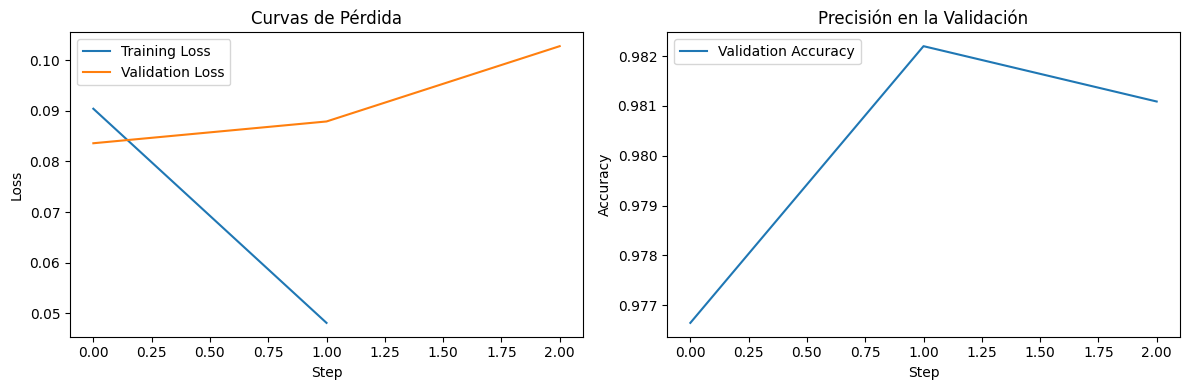

In [ ]:
import matplotlib.pyplot as plt

# Extraer las métricas del historial del Trainer
train_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]
accuracy = [entry['eval_accuracy'] for entry in trainer.state.log_history if 'eval_accuracy' in entry]

# Crear la figura y los ejes
plt.figure(figsize=(12, 4))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Curvas de Pérdida')
plt.legend()

# Gráfico de la precisión
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Precisión en la Validación')
plt.legend()

plt.tight_layout()
plt.show()

# Ejercicio 4: Análisis de Resultados

**Objetivo:** Evaluar y comparar el rendimiento del modelo BERT en español.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener las predicciones del modelo en los datos de validación
predictions = trainer.predict(val_dataset)
y_pred = predictions.predictions.argmax(-1)

# Extraer las etiquetas predichas y las etiquetas verdaderas
predicted_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

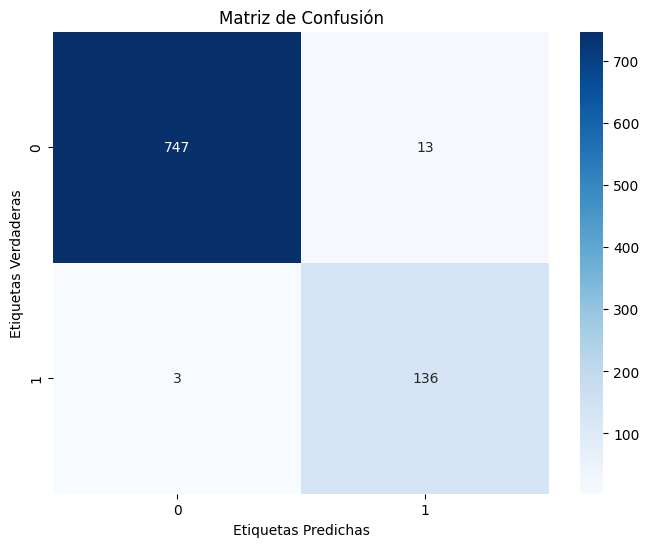

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Etiquetas Predichas")
plt.ylabel("Etiquetas Verdaderas")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Crear un diccionario con los datos de validación
val_data = {
    "input_ids": val_encodings,
    "attention_mask": val_masks
}

# Imprimir el informe de clasificación con precisión, recall, F1-score
print(classification_report(y_val, y_pred))

# Calcular métricas adicionales
target_names = [str(name) for name in data['Etiqueta'].unique()]
print(classification_report(y_val, y_pred, target_names=target_names))

# Evaluación detallada con trainer.evaluate()
eval_results = trainer.evaluate()
print(eval_results)

# Graficar la pérdida y la precisión durante el entrenamiento
plt.figure(figsize=(12, 4))



              precision    recall  f1-score   support

           0       1.00      0.98      0.99       760
           1       0.91      0.98      0.94       139

    accuracy                           0.98       899
   macro avg       0.95      0.98      0.97       899
weighted avg       0.98      0.98      0.98       899

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       760
           1       0.91      0.98      0.94       139

    accuracy                           0.98       899
   macro avg       0.95      0.98      0.97       899
weighted avg       0.98      0.98      0.98       899



{'eval_accuracy': 0.982202447163515, 'eval_loss': 0.08788371831178665, 'eval_runtime': 7.0275, 'eval_samples_per_second': 127.927, 'eval_steps_per_second': 16.08, 'epoch': 3.0}


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

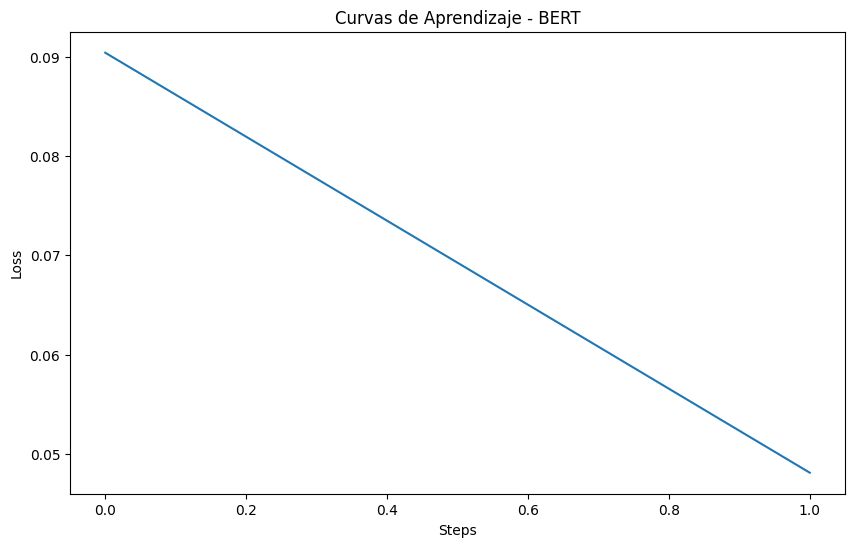

In [ ]:
# Visualización de resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
loss_values = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
plt.plot(loss_values)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Curvas de Aprendizaje - BERT')
plt.show()

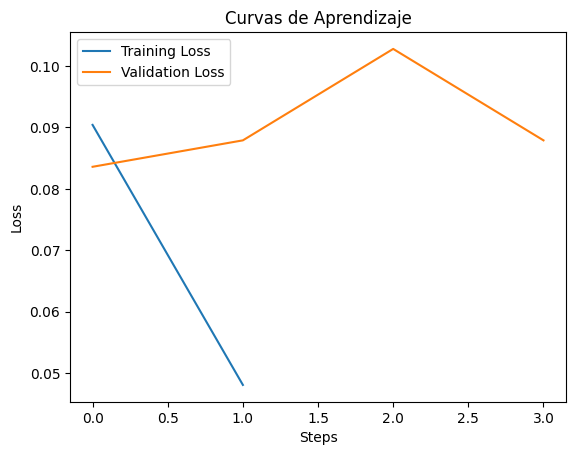

In [ ]:
# Extraer la pérdida de entrenamiento y validación
train_loss = [entry['loss'] for entry in trainer.state.log_history if 'loss' in entry]
val_loss = [entry['eval_loss'] for entry in trainer.state.log_history if 'eval_loss' in entry]

# Graficar las curvas
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Curvas de Aprendizaje')
plt.legend()
plt.show()

# Ejercicio 5: Informe y Conclusiones

**Objetivo:** Documentar los resultados obtenidos y discutir las implicaciones prácticas.

# Introducción

En este informe, evaluaremos y compararemos los modelos RNN, LSTM y BERT desarrollados para la clasificación de noticias en categorías especializadas como deportes, cultura, economía y justicia. Excluimos otras categorías no especializadas para enfocarnos en temas con un discurso específico y relevante.

# Evaluación de los Modelos

A continuación veremos un resumen de los datos obtenidos al aplicar los tres modelos:

In [ ]:
# Tabla en texto
Resumen_modelos = """
| Evaluación Módelos  | MODELO RNN  | MODELO LSTM   | MODELO BERT  |
|---------------------|-------------|---------------|--------------|
| "Precisión"         |    0,68     |     0,51      |     0,98     |
| "F1-Score"          |    0,68     |     0,42      |     0,99     |
| "Recall"            |    0,68     |     0,51      |     0,98     |
"""
print(Resumen_modelos)


| Evaluación Módelos  | MODELO RNN  | MODELO LSTM   | MODELO BERT  |
|---------------------|-------------|---------------|--------------|
| "Precisión"         |    0,68     |     0,51      |     0,98     |
| "F1-Score"          |    0,68     |     0,42      |     0,99     |
| "Recall"            |    0,68     |     0,51      |     0,98     |



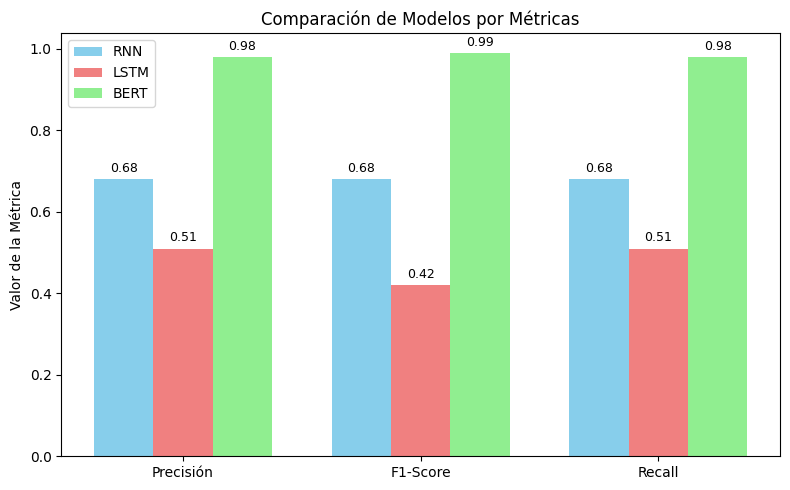

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de la tabla
metricas = ["Precisión", "F1-Score", "Recall"]
modelos = ["RNN", "LSTM", "BERT"]
valores = [
    [0.68, 0.68, 0.68],  # RNN
    [0.51, 0.42, 0.51],     # LSTM
    [0.98, 0.99, 0.98]      # BERT
]

# Configuración de la gráfica
x = np.arange(len(metricas))  # Posiciones en el eje X
ancho = 0.25  # Ancho de las barras

fig, ax = plt.subplots(figsize=(8, 5))

# Crear las barras para cada modelo
ax.bar(x - ancho, valores[0], width=ancho, label="RNN", color='skyblue')
ax.bar(x, valores[1], width=ancho, label="LSTM", color='lightcoral')
ax.bar(x + ancho, valores[2], width=ancho, label="BERT", color='lightgreen')

# Personalización del gráfico
ax.set_xticks(x)
ax.set_xticklabels(metricas)
ax.set_ylabel("Valor de la Métrica")
ax.set_title("Comparación de Modelos por Métricas")
ax.legend()

# Mostrar los valores encima de las barras
for i, modelo in enumerate(valores):
    for j, val in enumerate(modelo):
        ax.text(x[j] + (i-1)*ancho, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

A continuación veremos en detalle cada uno de ellos:

# Modelo RNN:

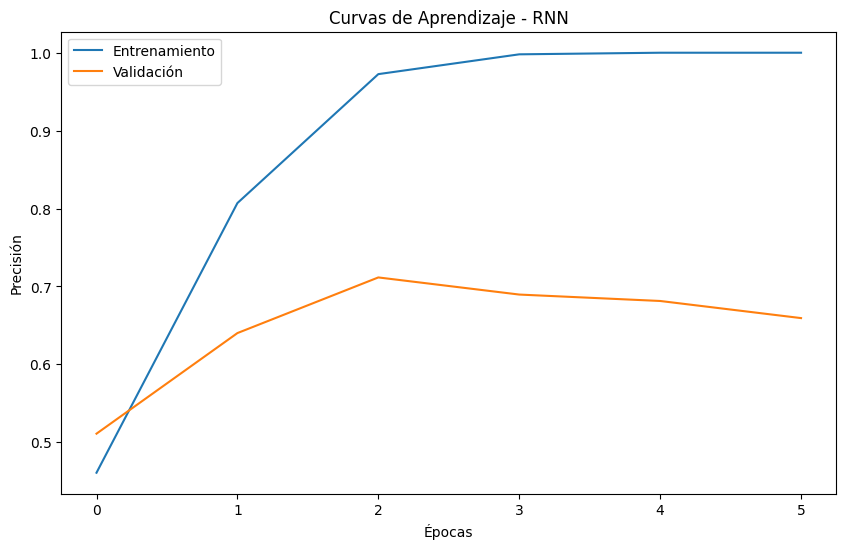

De la gráfica de curvas de aprendizaje - RNN, se puede evidenciar que el modelo en la etapa de entrenamiento tiene una curva de aprendizaje optima en dos o tres (2 a 3) épocas dado a que muestran un incremento constante en la precisión, a partir de la tercera (3) época, los datos de validación comienzan a disminuir lo que indica que el modelo se empieza a sobreajustar.
De otra parte, al comparar la curva de entrenamiento con la de validación se puede apreciar una gran brecha, lo cual indica que en la validación el modelo no es tan óptimo dado a que se está presentando overfitting (sobreajuste).
En conclusión, aunque el modelo logra una alta precisión en entrenamiento, la precisión en validación es más baja (alrededor de 0.7). Esto sugiere que el modelo no está generalizando bien.

## Ventajas modelo RNN:

--- Teniendo en cuenta que el lenguaje natural cuenta con entradas de longitudes diferentes, las redes neuronales son óptimas ya que permiten una clasificación de texto independientemente de la cantidad de diferentes de palabras.

--- Con el RNN podemos hacer labores de detección de temas gracias a la memoria interna con la cual se pueden capturar dependencias contextuales en una secuencia.

--- Permite contar con un enfoque que tiene en cuenta el contexto más que tratar palabras independientes, lo cual puede reducir la complejidad de los datos y mejorar la eficiencia.

--- Gracias a su arquitectura puede adaptarse a la clasificación multiclase, es decir, por temas o categorías. Como lo que nos ocupa para este taller.

## Desventajas modelo RNN:

--- Tiene una capacidad limitada para modelar dependencias a largo plazo debido al desvanecimiento de la gradiente.

--- Conlleva un tiempo de procesamiento elevado ya que procesan las secuencias de una en una, lo cual con grandes volúmenes de datos de texto puede resultar costoso en terminos de tiempo.

--- Este modelo desarrolla una arquitectura secuencial, con lo cual un token no se procesa hasta que se ha procesado el anterior. Lo cual conlleva paralelización del proceso de entrenamiento.


--- Requiere especial atención con los hiperparametros como el número de capas y longitud de la secuencia, para evitar sobreajuste o bajo rendimiento.

# Modelo LSTM:

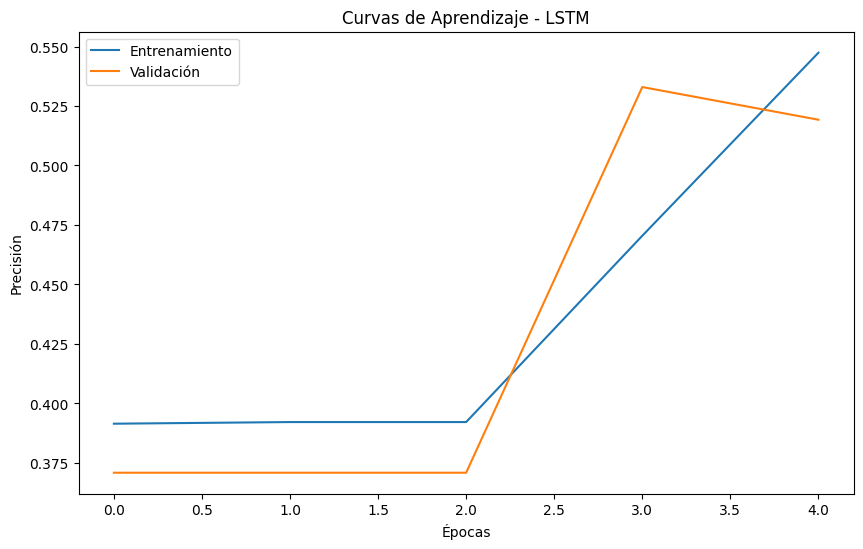

De acuerdo con la gráfica curvas de aprendizaje en el modelo LSTM, se puede analizar que durante el entrenamiento y validación, la precisión se mantuvo de manera constante por debajo de 0.4 y 0.375 respectivamente hasta la segunda (2) época, lo que puede indicar que el modelo cuenta con una baja tasa de aprendizaje.

A partir de la segunda época, la precisión comienza a mejorar tranto en entrenamiento como en validación por encima de 0.525hasta la tercera (3) época.

A partir de la época 3, la validación empiza a disminuir ligeramente, lo que puede sugerir que el modelo se está sobreajustando al conjunto de entrenamiento, perdiendo capacidad de generalización.

## Ventajas modelo LSTM:

--- Resuelve el problema de desvanecimiento de gradiente del RNN, lo cual representa un manejo eficiente de dependencias a largo plazo.

--- Este modelo permite un mayor control de la memoria y los flujos de información, con lo cual se puede trabajar adecuadamente la labor de clasificación de texto que requiere contexto a largo plazo.

--- El modelo tiene la capacidad de ofrecer buenas predicciones en contextos variables debido a su arquitectura que permite modelar dependencias contextuales profundas.

## Desventajas modelo LSTM:

--- Computacionalmente es más complejo que el modelo RNN debido a sus multiples puertos de control.

--- Se deben ejecutar técnicas de validación cruzada o regularización ya que es suseptible a que se sobreajuste a los datos de entrenamiento ya que tiene mayor cantidad de parámetros.

# Modelo BERT:

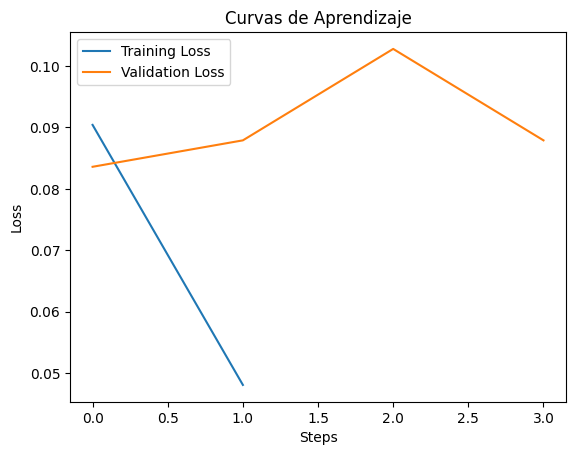

La gráfica de curvas de aprendizaje del modelo BERT, nos muestra las curvas validación y aprendizaje de la función de pérdida (Loss) en funsión de los pasos (Steps). De esta se puede interpretar que:
1. En el entrenamiento, la pérdida en el conjunto desciende rápidamente desde el inicio hasta por debajo de 0.05, lo que indica que el modelo está ajustándose bien a los datos del entrenamiento.
2. En la etapa de validación, la pérdida de validación es más alta que la del entrenamiento y aumenta significativamente hasta los 2.0 pasos, lo que podría deberse a que el modelo está comenzando a sobreajustarse al conjunto de entrenamiento.

Se puede concluir que el modelo podría no estar generalizando bien dado que, la pérdida de validación es consistentemente más alta que la de entrenamiento.


## Ventajas modelo BERT:

--- Al ser un modelo bidireccional puede capturar significados más profundos de las palabras dependiendo del contexto que las rodea.

--- Se puede preprocesar toda la secuencia simultaneamente a diferencia del RNN o LSTM que son secuenciales con lo cual hace más demorado el proceso.

--- Se puede ajustar a tareas especificas despues de su preentrenamiento, con lo cual no necesita entrenarse desde cero.

## Desventajas modelo BERT:



--- Altos costos computacionales y uso intensivo de memoria para entrenarse.

--- Tiende a sobreajustarse cuando se usa para datasets pequeños.



# Conclusión

Del análisis efectuado a los resultados de los modelos LSTM, RNN y BERT, se puede concluir que:



*   Modelo RNN: mostró una alta precisión en el conjunto de entrenamiento, sin embargo, tuvo un rendimiento significativamente menor en el conjunto de validación presentando sobreajuste. Su simplicidad lo hace menos efectivo para tareas complejas de secuencias, con un rendimiento inferior.
*   Modelo LSTM: mostró una mejora lenta durante las primeras épocas y un aumento brusco en el rendimiento tanto en entrenamiento como en validación, tiene mejor capacidad que RNN para manejar dependencias en el tiempo, pero su precisión fue limitada y mostró sobreajuste.
*   Modelo BERT: Aunque la pérdida de validación fue inicialmente más alta que la de entrenamiento, el modelo mostró  un mejor equilibrio en las curvas de aprendizaje y generalización,su rendimiento general (evaluado a través de la pérdida) lo posiciona como el mejor modelo dado que:
    1. Presenta un descenso más consistente en la pérdida, lo que sugiere un mejor equilibrio entre ajuste y generalización.
    2. Al ser diseñado específicamente para tareas de NLP, maneja de una forma más eficiente la relación semántica que existe entre las palabras.
    3. Mostró mayor robustez y menor tendencia al sobreajuste en comparación con LSTM y RNN


## Recomendaciones:

Se observa que para hacer más óptimo el resultado del modelo STML (que fue el que arrojó resultados más bajos) se podría aplicar estrategías como:


*   Implementar técnicas de regularización como Dropout o Weight Decay.
*   Usar un optimizador avanzado como AdamW.
*   Utilizar Early Stopping basado en la pérdida de validación para detener el entrenamiento antes de que ocurra sobreajuste.
*   Ampliar el conjunto de datos de entrenamiento para abordar la desbalance de clases.


De otra parte, para la elección del modelo se debe evaluar la naturaleza específica de la tarea, los requisitos de rendimiento y la capacidad computacional.



